In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
from glob import glob
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint

In [2]:
from keras.applications.resnet import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input

In [3]:
#organize data
os.chdir('/content/drive/MyDrive/program/appleLeafAugmentedDataset')

In [4]:
train_path = "/content/drive/MyDrive/program/appleLeafAugmentedDataset/train"
valid_path = "/content/drive/MyDrive/program/appleLeafAugmentedDataset/valid"
test_path = "/content/drive/MyDrive/program/appleLeafAugmentedDataset/test"

In [5]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input) \
  .flow_from_directory(directory=train_path, target_size=(224,224), classes=['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy'], batch_size=32)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input) \
  .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy'], batch_size=32)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input) \
  .flow_from_directory(directory=test_path, target_size=(224,224), classes=['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy'], batch_size=32, shuffle=False)


Found 3248 images belonging to 4 classes.
Found 928 images belonging to 4 classes.
Found 464 images belonging to 4 classes.


In [6]:
imgs, labels = next(train_batches)

In [7]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


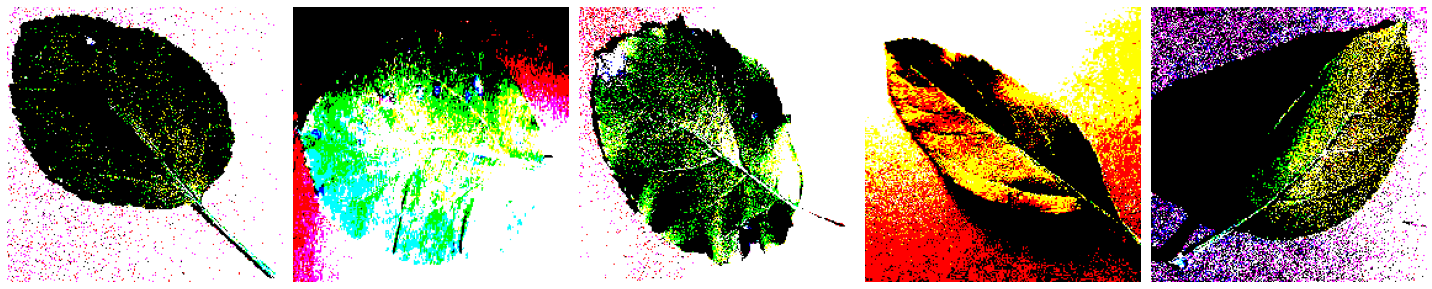

[[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]


In [8]:
plotImages(imgs)
print(labels)

In [9]:
resnet50_model = tf.keras.applications.resnet.ResNet50()

102981632/102967424 [==============================] - 1s 0us/step


In [10]:
resnet50_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [11]:
x = resnet50_model.layers[-1].output
output = Dense(units=4, activation='softmax')(x)

In [12]:
model = Model(inputs=resnet50_model.input, outputs=output)

In [13]:
for layer in model.layers[:-23]:
  layer.trainable=False

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [15]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer=Adam(learning_rate=0.0001),
  metrics=['accuracy']
)

In [16]:
model_path = '/content/drive/MyDrive/My ML Project /DL Project/CNN/appleLeafMand/apple_leaf_resnet50_model_v1.h5'
checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', verbose=2, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [17]:
# fit the model
# Run the cell. It will take some time to execute
history = model.fit(x=train_batches,
  validation_data=valid_batches,
  epochs=20,
  callbacks=callbacks_list
)

Epoch 1/20
102/102 [==============================] - 889s 8s/step - loss: 1.3294 - accuracy: 0.8984 - val_loss: 1.3082 - val_accuracy: 0.9612

Epoch 00001: val_accuracy improved from -inf to 0.96121, saving model to /content/drive/MyDrive/My ML Project /DL Project/CNN/appleLeafMand/apple_leaf_resnet50_model_v1.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
102/102 [==============================] - 33s 325ms/step - loss: 1.2949 - accuracy: 0.9917 - val_loss: 1.2861 - val_accuracy: 0.9925

Epoch 00002: val_accuracy improved from 0.96121 to 0.99246, saving model to /content/drive/MyDrive/My ML Project /DL Project/CNN/appleLeafMand/apple_leaf_resnet50_model_v1.h5
Epoch 3/20
102/102 [==============================] - 33s 326ms/step - loss: 1.2771 - accuracy: 0.9901 - val_loss: 1.2672 - val_accuracy: 0.9892

Epoch 00003: val_accuracy did not improve from 0.99246
Epoch 4/20
102/102 [==============================] - 33s 321ms/step - loss: 1.2576 - accuracy: 0.9951 - val_loss: 1.2496 - val_accuracy: 0.9914

Epoch 00004: val_accuracy did not improve from 0.99246
Epoch 5/20
102/102 [==============================] - 33s 322ms/step - loss: 1.2405 - accuracy: 0.9963 - val_loss: 1.2320 - val_accuracy: 0.9968

Epoch 00005: val_accuracy improved from 0.99246 to 0.99677, saving model to /content/drive/MyDrive/My ML Project /DL Project/CNN/ap

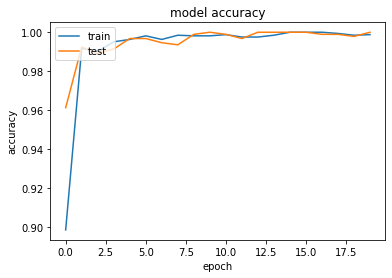

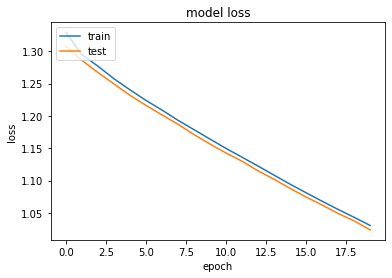

In [18]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
test_labels = test_batches.classes
predictions = model.predict(x=test_batches, verbose=0)
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

In [20]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [21]:
test_batches.class_indices

{'Apple___Apple_scab': 0,
 'Apple___Black_rot': 1,
 'Apple___Cedar_apple_rust': 2,
 'Apple___healthy': 3}

Confusion matrix, without normalization
[[100   0   0   0]
 [  0 100   0   0]
 [  0   0 100   0]
 [  0   0   0 164]]


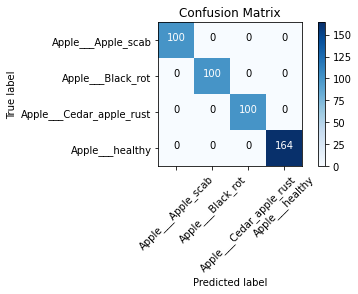

In [22]:
cm_plot_labels=['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [23]:
from sklearn.metrics import classification_report
cr = classification_report(y_true=test_labels, y_pred=predictions.argmax(axis=1), target_names=cm_plot_labels)
print(cr)

                          precision    recall  f1-score   support

      Apple___Apple_scab       1.00      1.00      1.00       100
       Apple___Black_rot       1.00      1.00      1.00       100
Apple___Cedar_apple_rust       1.00      1.00      1.00       100
         Apple___healthy       1.00      1.00      1.00       164

                accuracy                           1.00       464
               macro avg       1.00      1.00      1.00       464
            weighted avg       1.00      1.00      1.00       464

